# 1. Import and setup

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scstat
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [50]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [51]:
RANDOM_STATE=42

In [52]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(40, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        if 'cluster' in label:
            values = [df[df[label] == cluster][feature] for cluster in df[label].unique()]
            statistic, p_value = scstat.f_oneway(*values)
        else:
            statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                    df[df[label] == value[1]][feature].dropna())
        p_vals.append(round(p_value,3))
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [53]:
df = pd.read_csv('../dataset/icd_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,...,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,23260768,0,F,60,NaN,21.9,24.0,1.2,142.0,75.0,...,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,23059383,0,F,72,2147-11-06T18:30:00,34.3,29.0,1.3,55.0,32.0,...,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,20779074,0,F,88,NaN,33.6,18.0,1.1,130.0,62.0,...,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,20772091,0,M,34,2179-02-25T16:08:00,30.7,13.0,0.5,112.0,66.0,...,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,21453368,0,F,38,2133-04-05T10:20:00,25.7,24.0,0.9,176.0,106.0,...,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [54]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    373
Dead        81
Name: count, dtype: int64

In [55]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

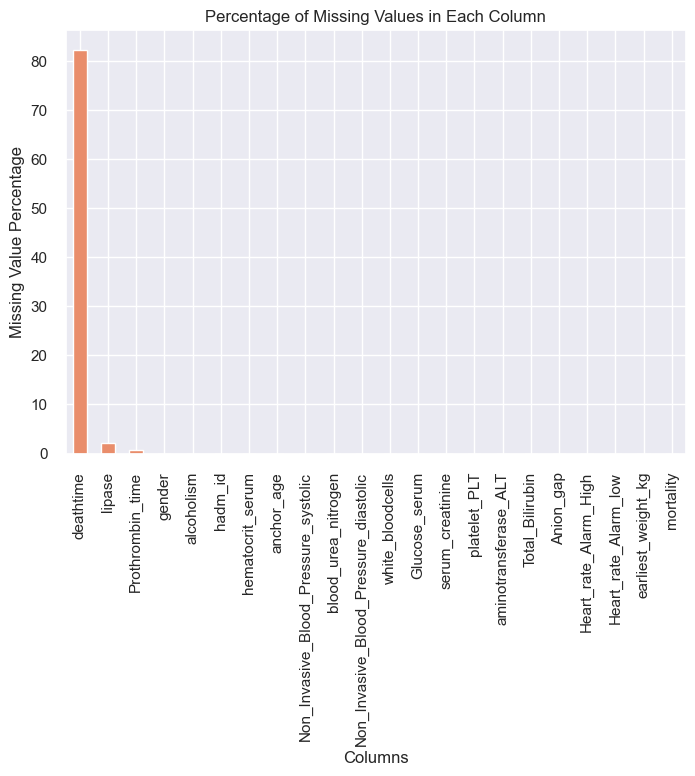

In [56]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [57]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    82.15859
dtype: float64

In [58]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead


In [59]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.000000    441
0.047619     13
Name: count, dtype: int64

In [60]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,454.00,454.00,454.00,454.00,454.00,454.00,454.00,454.00,444.00,454.00,454.00,454.00,451.00,454.0,454.00,454.00,454.00,454.00,454.00
mean,24933999.80,0.22,58.60,33.83,29.54,1.66,128.64,73.23,603.17,13.88,159.63,227.47,17.16,226.8,2.77,16.19,124.06,54.46,84.62
std,2897739.39,0.41,17.23,7.17,25.10,1.71,26.53,19.98,945.91,8.83,126.40,140.31,9.44,798.9,5.23,5.57,10.69,8.10,23.20
min,20009550.00,0.00,22.00,16.00,3.00,0.10,55.00,12.00,5.00,0.10,35.00,10.00,8.80,2.0,0.10,5.00,50.00,20.00,32.00
25%,22386114.50,0.00,46.25,28.70,13.00,0.70,110.00,59.00,57.75,8.40,102.00,129.25,13.00,24.0,0.50,13.00,120.00,50.00,68.75
50%,25102125.00,0.00,57.50,33.00,22.00,1.10,127.00,71.50,210.00,12.05,126.00,199.50,14.40,51.0,1.00,15.00,120.00,50.00,80.50
75%,27559023.00,0.00,72.00,38.38,37.00,1.80,146.00,84.00,772.25,17.85,178.00,286.75,17.05,150.0,2.80,18.00,130.00,60.00,98.20
max,29966638.00,1.00,91.00,56.50,173.00,14.40,222.00,134.00,6095.00,77.80,1638.00,942.00,93.20,9582.0,46.50,49.00,180.00,135.00,168.20


In [61]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,454,454
unique,2,2
top,M,Survive
freq,266,373


In [62]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  454
Number of duplication 0


In [63]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [64]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [65]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead


In [66]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,gender
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,1,0
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,0,0
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,1,0
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,0,1
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,0,0


In [67]:
X = X.fillna(X.median())

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -1.04050685,
         0.46600234, -1.18949301],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.84635974,
        -2.14591199, -1.18949301],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -1.07502189,
         0.46600234, -1.18949301],
       ...,
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.43932554,
         0.46600234,  0.84069431],
       [-0.5280845 ,  0.83662316, -0.70259287, ..., -0.77301528,
         0.46600234,  0.84069431],
       [-0.5280845 ,  1.01088233,  0.05102836, ..., -0.54435313,
         0.46600234,  0.84069431]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [69]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
X = X[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 394


array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -1.04050685,
         0.46600234, -1.18949301],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.84635974,
        -2.14591199, -1.18949301],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -1.07502189,
         0.46600234, -1.18949301],
       ...,
       [-0.5280845 , -0.8478822 ,  0.06498431, ...,  0.32715165,
         0.46600234,  0.84069431],
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.43932554,
         0.46600234,  0.84069431],
       [-0.5280845 ,  1.01088233,  0.05102836, ..., -0.54435313,
         0.46600234,  0.84069431]])

In [70]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca

,PC1,PC2,PC3
0,0.279980,-1.998477,-1.180486
1,3.653448,-0.464053,0.350293
2,1.240309,-1.017045,-1.613759
3,-0.164842,-1.023233,0.524394
4,-0.953700,0.064909,-0.819146
...,...,...,...
389,0.888493,-0.668612,-1.207766
390,-1.389615,0.023529,2.599003
391,-1.292489,0.598989,-0.217630
392,-0.626498,-0.175729,0.086041


# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [71]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [72]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

232709812.30360404

In [73]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([90.13950734, 90.81652424, 91.37246408, 91.76374269, 92.14272506,
       92.41615296, 92.6535884 , 92.77398495, 92.90188771, 93.07675526,
       93.22159276, 93.3378334 , 93.38324115])

Text(0.5, 1.0, 'Total Variance Explained')

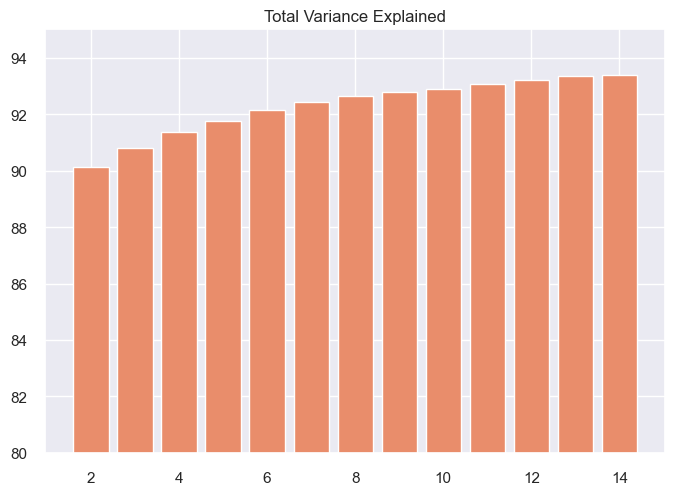

In [74]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

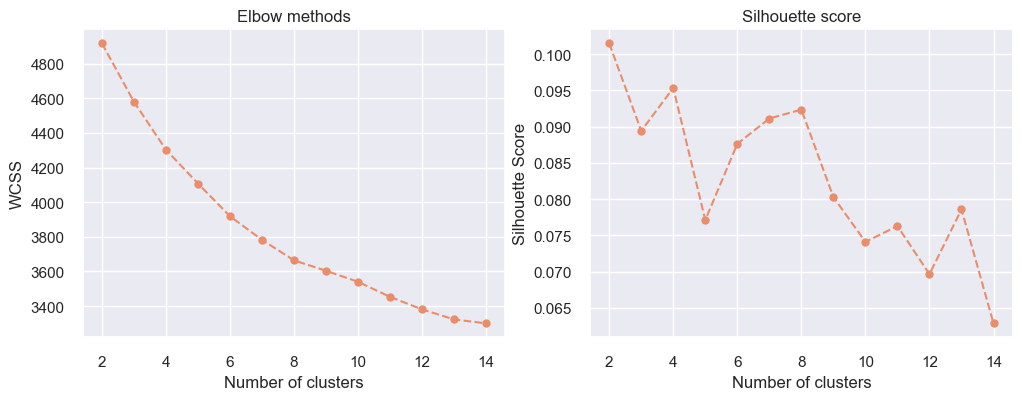

In [75]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

#### On Yellowbrick

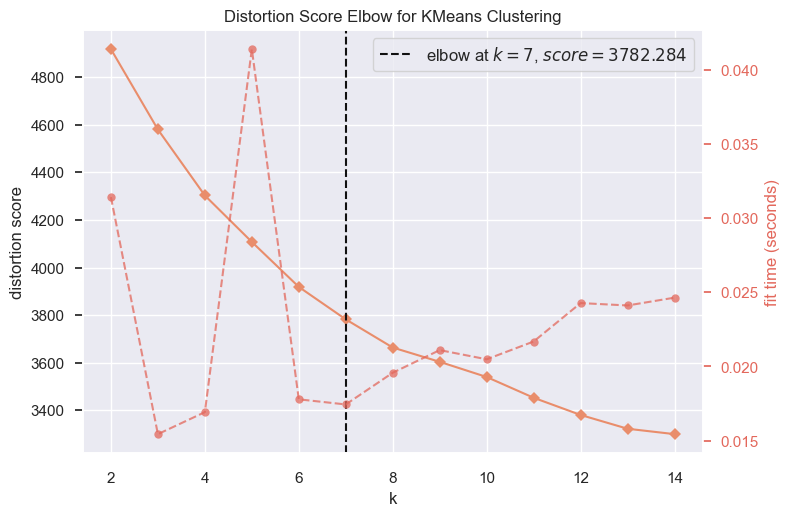

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [77]:
kmeans_cluster = 6

## 5.2. Fitting the model

In [78]:
# Fit model
kmeans = KMeans(n_clusters=kmeans_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
X_pca['cluster'] = df_clean['cluster']
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive,2
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead,4
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive,2
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead,4
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead,0


In [79]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {kmeans_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 6 clusters, resulting on 3918.65 WCSS and 0.09 silhouette score


In [80]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,1.081081e-01,51.094595,39.660811,21.378378,1.109459,158.040541,95.851351,621.256757,16.697297,160.743243,252.864865,15.306757,144.067568,1.732432,16.121622,125.675676,54.662162,91.743243,9.054054e-01,8.108108e-01
1,1.515152e-01,61.757576,33.966667,69.545455,4.603030,118.757576,59.909091,792.424242,13.224242,176.787879,188.393939,17.239394,184.909091,2.745455,21.878788,122.575758,52.878788,86.712121,7.272727e-01,5.757576e-01
2,-8.326673e-17,61.947368,31.468421,20.873684,1.038947,121.484211,67.336842,443.221053,13.355789,127.547368,256.684211,15.701053,141.536842,1.822105,13.936842,123.736842,52.947368,76.121053,1.000000e+00,-2.220446e-16
3,-2.775558e-17,63.185185,32.664198,22.827160,1.198765,118.617284,65.320988,383.765432,11.406173,139.444444,203.506173,16.954321,134.345679,2.014815,13.567901,121.543210,54.197531,91.754321,1.000000e+00,9.876543e-01
4,2.380952e-02,74.857143,33.311905,37.214286,1.478571,118.928571,64.357143,480.666667,14.409524,154.047619,204.714286,16.676190,207.833333,3.135714,16.785714,126.666667,52.738095,75.773810,-4.440892e-16,5.238095e-01
5,1.000000e+00,46.608696,33.485507,17.420290,1.053623,129.536232,80.608696,394.289855,11.317391,154.521739,211.855072,14.362319,160.811594,2.553623,15.376812,123.623188,54.782609,83.173913,9.565217e-01,6.956522e-01


# 5. DBSCAN

In [81]:
# Applying DBScan
dbscan = DBSCAN(eps=3)
clusters = dbscan.fit_predict(X_cleaned)

df_clean['DB_cluster'] = clusters
X_pca['DB_cluster'] = clusters
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    271
-1    118
 1      5
Name: count, dtype: int64

In [82]:
db_cluster = 3

In [83]:
silhouette_score(X_cleaned, X_pca['DB_cluster'])

0.062402579842083986

# K-Prototypes

In [84]:
# Drop gender
X2 = df_clean.drop(['hadm_id', 'gender', 'mortality', 'alcoholism', 'cluster', 'DB_cluster'], axis=1)
X2 = X2.fillna(X2.median())
X2.head()

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,34,30.7,13.0,0.5,112.0,66.0,183.0,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [85]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X2)
X_scaled2

array([[ 0.06697982, -1.69404635, -0.12587991, ..., -0.44400621,
        -0.74794902, -1.05619678],
       [ 0.75842213,  0.04029133,  0.11771874, ...,  0.71070301,
        -0.74794902, -0.85695041],
       [ 1.68034521, -0.05761483, -0.4181983 , ...,  0.71070301,
        -0.74794902, -1.09161836],
       ...,
       [-0.85494326,  0.04029133,  0.41003712, ..., -0.44400621,
         1.21013679,  0.34738317],
       [ 0.47032116, -0.14153439, -0.46691803, ..., -0.44400621,
         1.21013679,  0.46250329],
       [ 0.9889029 ,  0.02630474,  0.70235551, ...,  0.71070301,
         1.21013679, -0.54701162]])

In [86]:
X_scaled2 = np.c_[X_scaled2, X['gender'], X['alcoholism'], X['mortality']]

In [87]:
X_scaled2.shape

(394, 20)

In [88]:
costs = []
n_clusters = []
ss = []

for i in range(2, 15):
    kproto = KPrototypes(n_clusters=i, random_state=RANDOM_STATE)
    clusters = kproto.fit_predict(X_scaled2, categorical=[17,18,19])
    
    costs.append(kproto.cost_)
    n_clusters.append(i)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled2, clusters)
    ss.append(sil_score)

Text(0.5, 1.0, 'Total Variance Explained')

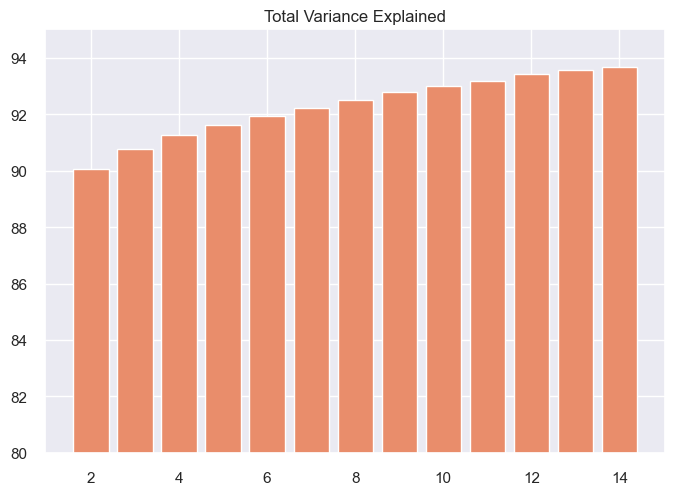

In [89]:
plt.bar(range(2,15), (1 - (np.array(costs) / np.sum(costs))) * 100)
plt.ylim((80,95))
plt.title("Total Variance Explained")

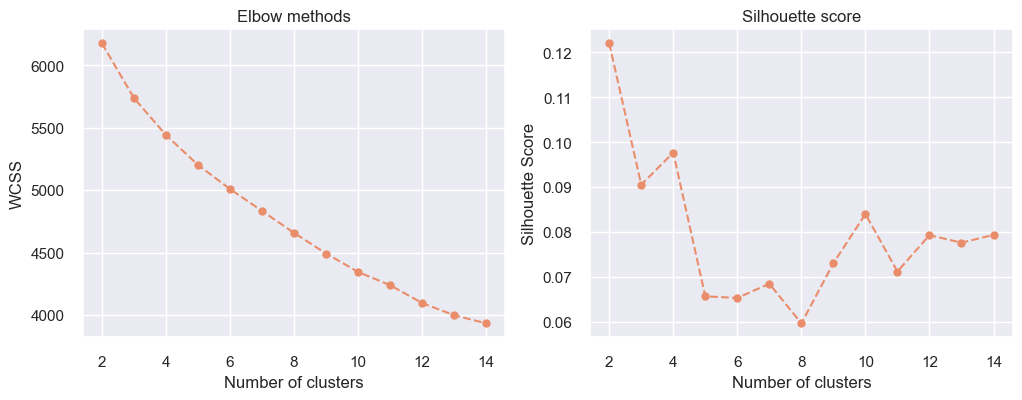

In [90]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), costs, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

In [92]:
proto_cluster = 4

In [103]:
costs[2]

5440.021241460276

In [104]:
ss

[0.12199099081341919,
 0.09052047449865741,
 0.09767211409002097,
 0.06565849893916344,
 0.06529458404997762,
 0.0684585226272283,
 0.05963217147418293,
 0.07304335571474894,
 0.08398957899372914,
 0.07118758388372436,
 0.07928276817422346,
 0.07760662315988975,
 0.07935466516989872]

In [95]:
kproto = KPrototypes(n_clusters=proto_cluster, random_state=RANDOM_STATE)
df_clean['proto_cluster'] = kproto.fit_predict(X_scaled2, categorical=[17,18,19])
X_pca['proto_cluster'] = df_clean['proto_cluster']

In [96]:
kproto._enc_cluster_centroids[1]

array([[0, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]], dtype=object)

In [97]:
scaler2.inverse_transform(kproto._enc_cluster_centroids[0])

array([[ 60.46236559,  31.52634409,  19.07526882,   0.94892473,
        119.45698925,  68.2311828 , 323.7688172 ,  12.36021505,
        125.11290323, 257.10752688,  14.81075269,  99.34408602,
          1.62849462,  13.24193548, 123.38709677,  53.06451613,
         80.25483871],
       [ 62.075     ,  31.5125    ,  28.6       ,   1.6775    ,
        115.2       ,  61.65      , 563.675     ,  12.4975    ,
        126.5       , 152.525     ,  24.71      , 615.25      ,
          6.8875    ,  18.5       , 121.875     ,  51.625     ,
         82.0325    ],
       [ 67.71428571,  34.42321429,  63.83928571,   3.62142857,
        124.08928571,  63.73214286, 571.78571429,  13.82321429,
        166.375     , 188.32142857,  15.80892857, 101.48214286,
          1.45      ,  19.17857143, 121.96428571,  53.83928571,
         88.47678571],
       [ 50.54464286,  38.82678571,  19.70535714,   1.05535714,
        151.07142857,  91.9375    , 694.02678571,  14.98035714,
        184.15178571, 219.15178571,

In [98]:
pd.DataFrame(np.c_[scaler2.inverse_transform(kproto._enc_cluster_centroids[0]), kproto._enc_cluster_centroids[1]],
            columns=list(X2.columns)+['gender', 'alcoholism', 'mortality'])

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,alcoholism,mortality
0,60.462366,31.526344,19.075269,0.948925,119.456989,68.231183,323.768817,12.360215,125.112903,257.107527,14.810753,99.344086,1.628495,13.241935,123.387097,53.064516,80.254839,0,0,1
1,62.075,31.5125,28.6,1.6775,115.2,61.65,563.675,12.4975,126.5,152.525,24.71,615.25,6.8875,18.5,121.875,51.625,82.0325,1,0,1
2,67.714286,34.423214,63.839286,3.621429,124.089286,63.732143,571.785714,13.823214,166.375,188.321429,15.808929,101.482143,1.45,19.178571,121.964286,53.839286,88.476786,1,0,1
3,50.544643,38.826786,19.705357,1.055357,151.071429,91.9375,694.026786,14.980357,184.151786,219.151786,14.545536,108.4375,1.816071,16.3125,126.25,55.848214,89.930357,1,0,1


# Result

In [99]:
def stat_cum(cluster, clusters):
    cluster0 = df_clean[clusters == cluster]
    mort_rate = round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Mortality rate is {mort_rate}")
    display(round(cluster0.describe(),2))
    return cluster0.describe().loc['mean',:], mort_rate

## Value Counts

In [100]:
df_clean['cluster'].value_counts()

cluster
2    95
3    81
0    74
5    69
4    42
1    33
Name: count, dtype: int64

In [101]:
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    271
-1    118
 1      5
Name: count, dtype: int64

In [102]:
df_clean['proto_cluster'].value_counts()

proto_cluster
0    186
3    112
2     56
1     40
Name: count, dtype: int64

## Statistics

In [105]:
stats = pd.DataFrame(index=list(df_clean.columns) + ['mortality_rate'],
                     columns=[])

In [106]:
# for i in range(kmeans_cluster):
#     print("====================== Cluster %s =========================" % (i))
#     kmeans_result, mort_rate = stat_cum(i, df_clean.cluster)
#     stats["Kmeans" + str(i)] = 0
#     stats.loc[kmeans_result.index, "Kmeans" + str(i)] = kmeans_result.values
#     stats.loc['mortality_rate', "Kmeans" + str(i)] = mort_rate

In [107]:
for i in range(-1,-1+db_cluster):
    print("====================== Cluster %s =========================" % (i))
    db_result, mort_rate = stat_cum(i, df_clean.DB_cluster)
    stats["DB" + str(i)] = 0
    stats.loc[db_result.index, "DB" + str(i)] = db_result.values
    stats.loc['mortality_rate', "DB" + str(i)] = mort_rate

====================== Cluster -1 =========================
Percentage of women and men (respectively) 41.53 and 58.47
Mortality rate is 40.68


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,118.00,118.00,118.00,118.00,118.00,118.00,118.00,118.00,112.00,118.00,...,118.00,116.00,118.00,118.00,118.00,118.00,118.00,118.00,118.0,118.00
mean,25160829.44,0.22,59.83,35.14,38.30,2.16,131.21,74.45,799.12,14.29,...,197.13,18.49,259.52,3.10,18.36,125.55,53.98,85.38,-1.0,1.83
std,3012696.72,0.42,18.35,7.94,26.25,1.69,29.83,22.97,910.28,8.84,...,131.46,8.25,507.33,4.27,6.08,11.11,5.53,22.78,0.0,1.03
min,20009550.00,0.00,25.00,20.70,3.00,0.40,73.00,12.00,8.00,0.10,...,18.00,8.80,6.00,0.10,8.00,100.00,30.00,47.40,-1.0,0.00
25%,22364381.00,0.00,47.00,28.72,18.00,0.90,109.00,59.00,105.00,7.62,...,101.50,13.70,28.50,0.50,14.00,120.00,50.00,69.00,-1.0,1.00
50%,25466095.00,0.00,60.00,34.75,32.50,1.50,131.00,70.00,375.50,12.70,...,160.50,15.40,56.00,1.20,17.00,120.00,50.00,80.10,-1.0,2.00
75%,28004954.25,0.00,75.00,41.05,53.00,2.70,151.00,84.75,1344.25,19.68,...,274.75,19.23,218.50,3.88,21.75,130.00,60.00,99.88,-1.0,3.00
max,29961750.00,1.00,91.00,54.30,110.00,7.60,207.00,134.00,3516.00,42.80,...,610.00,47.80,2976.00,17.90,35.00,160.00,70.00,163.30,-1.0,3.00


====================== Cluster 0 =========================
Percentage of women and men (respectively) 42.44 and 57.56
Mortality rate is 2.95


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,271.00,271.00,271.00,271.00,271.00,271.00,271.00,271.00,271.00,271.00,...,271.00,270.00,271.00,271.00,271.00,271.00,271.00,271.00,271.0,271.00
mean,24816344.51,0.21,58.14,33.47,21.45,1.12,128.57,73.88,374.56,12.87,...,239.20,14.78,108.38,1.80,14.22,123.10,53.75,84.22,0.0,1.00
std,2909603.07,0.41,16.92,6.79,15.08,0.80,23.58,17.84,526.55,6.67,...,130.56,3.66,170.50,1.92,3.23,7.33,4.93,22.64,0.0,1.33
min,20024364.00,0.00,22.00,17.70,3.00,0.10,76.00,26.00,5.00,0.10,...,10.00,9.40,2.00,0.10,5.00,100.00,40.00,32.00,0.0,0.00
25%,22379024.50,0.00,46.00,28.75,11.00,0.60,111.00,61.50,43.50,8.40,...,158.00,12.80,22.00,0.60,12.00,120.00,50.00,69.00,0.0,0.00
50%,24877202.00,0.00,56.00,32.90,18.00,0.90,126.00,73.00,146.00,11.80,...,215.00,14.10,46.00,0.90,14.00,120.00,50.00,81.30,0.0,0.00
75%,27320016.50,0.00,70.00,37.30,27.00,1.30,143.00,84.00,539.50,16.95,...,291.50,15.40,133.50,2.40,16.00,120.00,60.00,97.70,0.0,3.00
max,29966638.00,1.00,91.00,56.50,99.00,5.70,201.00,133.00,3705.00,32.80,...,690.00,45.10,1730.00,11.30,25.00,160.00,60.00,165.60,0.0,3.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 20.0 and 80.0
Mortality rate is 100.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,5.00,5.0,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.0,5.00
mean,24671550.60,0.0,73.20,36.76,28.20,1.44,74.20,43.20,57.75,15.66,...,185.80,15.92,184.20,1.70,17.00,124.00,54.00,67.40,1.0,0.20
std,2169307.93,0.0,13.18,3.92,12.38,0.21,18.59,9.15,69.05,3.97,...,124.65,2.51,311.58,0.88,2.45,5.48,5.48,8.11,0.0,0.45
min,21905572.00,0.0,54.00,34.00,13.00,1.20,55.00,32.00,10.00,9.60,...,64.00,12.20,23.00,0.20,14.00,120.00,50.00,60.00,1.0,0.00
25%,23059383.00,0.0,72.00,34.30,19.00,1.30,68.00,38.00,20.50,14.30,...,116.00,14.50,27.00,1.60,15.00,120.00,50.00,64.00,1.0,0.00
50%,25103103.00,0.0,73.00,34.50,29.00,1.40,69.00,41.00,30.50,16.50,...,145.00,17.20,49.00,2.20,18.00,120.00,50.00,65.00,1.0,0.00
75%,26097204.00,0.0,76.00,37.80,37.00,1.60,74.00,51.00,67.75,17.90,...,219.00,17.50,82.00,2.20,18.00,130.00,60.00,66.80,1.0,0.00
max,27192491.00,0.0,91.00,43.20,43.00,1.70,105.00,54.00,160.00,20.00,...,385.00,18.20,740.00,2.30,20.00,130.00,60.00,81.20,1.0,1.00


In [108]:
for i in range(proto_cluster):
    print("====================== Cluster %s =========================" % (i))
    proto_result, mort_rate = stat_cum(i, df_clean.proto_cluster)
    stats["Kproto" + str(i)] = 0
    stats.loc[proto_result.index, "Kproto" + str(i)] = proto_result.values
    stats.loc['mortality_rate', "Kproto" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 52.15 and 47.85
Mortality rate is 11.83


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00,182.00,186.00,...,186.00,184.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.0
mean,24769372.94,0.16,60.46,31.53,19.08,0.95,119.46,68.23,326.86,12.36,...,257.11,14.82,99.34,1.63,13.24,123.39,53.06,80.25,-0.06,0.0
std,2835659.13,0.37,17.24,5.38,10.90,0.52,20.51,14.38,489.36,6.49,...,139.21,3.25,146.60,1.70,2.85,8.42,4.71,22.48,0.31,0.0
min,20101858.00,0.00,22.00,17.70,3.00,0.20,68.00,26.00,5.00,0.10,...,17.00,9.40,2.00,0.10,5.00,100.00,40.00,32.00,-1.00,0.0
25%,22388656.25,0.00,48.00,27.72,11.00,0.60,106.00,59.00,37.75,7.70,...,164.75,12.90,21.00,0.50,11.00,120.00,50.00,65.03,0.00,0.0
50%,25032747.00,0.00,59.00,31.25,17.00,0.80,118.50,68.00,129.50,11.05,...,227.00,14.10,40.00,0.90,13.00,120.00,50.00,76.95,0.00,0.0
75%,27011260.75,0.00,73.00,35.08,24.75,1.20,135.75,78.00,410.50,16.50,...,319.50,15.62,119.75,2.20,15.00,120.00,60.00,92.98,0.00,0.0
max,29956550.00,1.00,91.00,47.30,64.00,3.20,185.00,129.00,3165.00,32.10,...,690.00,34.30,879.00,7.70,22.00,160.00,60.00,165.60,1.00,0.0


====================== Cluster 1 =========================
Percentage of women and men (respectively) 40.0 and 60.0
Mortality rate is 30.0


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,40.00,40.00,40.00,40.00,40.0,40.00,40.00,40.00,39.00,40.00,...,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.0
mean,25049285.95,0.25,62.08,31.51,28.6,1.68,115.20,61.65,573.44,12.50,...,152.52,24.71,615.25,6.89,18.50,121.88,51.62,82.03,-0.70,1.0
std,2959237.21,0.44,19.54,6.99,18.1,1.12,27.53,18.80,663.59,7.46,...,95.74,9.91,771.07,5.45,5.75,7.40,5.36,17.90,0.52,0.0
min,20079585.00,0.00,25.00,20.30,3.0,0.40,55.00,12.00,10.00,0.10,...,17.00,11.40,21.00,0.20,8.00,100.00,30.00,47.40,-1.00,1.0
25%,22852211.00,0.00,46.00,25.28,15.0,0.90,98.75,51.00,112.50,7.20,...,82.75,17.70,84.00,2.18,13.75,120.00,50.00,70.50,-1.00,1.0
50%,25188777.00,0.00,62.50,31.85,27.5,1.30,111.50,60.50,274.00,11.95,...,127.50,22.30,202.00,6.10,18.00,120.00,50.00,80.35,-1.00,1.0
75%,27850532.25,0.25,79.75,35.62,37.5,2.12,130.75,73.25,820.50,16.27,...,210.50,28.20,1096.00,9.30,22.50,120.00,50.00,88.80,0.00,1.0
max,29903947.00,1.00,91.00,45.80,99.0,5.30,185.00,108.00,2596.00,30.00,...,400.00,47.80,2976.00,17.90,35.00,150.00,60.00,127.00,1.00,1.0


====================== Cluster 2 =========================
Percentage of women and men (respectively) 35.71 and 64.29
Mortality rate is 28.57


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,...,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.0
mean,24963359.41,0.11,67.71,34.42,63.84,3.62,124.09,63.73,571.79,13.82,...,188.32,15.81,101.48,1.45,19.18,121.96,53.84,88.48,-0.62,2.0
std,3048045.66,0.31,14.09,7.62,20.47,1.58,23.47,14.92,726.72,8.88,...,103.45,4.84,148.25,1.50,5.70,6.37,4.86,22.16,0.49,0.0
min,20009550.00,0.00,31.00,21.50,33.00,1.40,75.00,39.00,8.00,2.40,...,10.00,10.80,6.00,0.10,12.00,100.00,50.00,47.10,-1.00,2.0
25%,22175510.00,0.00,57.00,28.68,47.75,2.40,109.00,54.25,68.75,7.68,...,120.00,13.28,22.75,0.40,15.00,120.00,50.00,74.75,-1.00,2.0
50%,25235698.50,0.00,70.00,32.30,57.50,3.15,122.50,62.00,247.50,10.75,...,175.00,14.45,34.50,0.85,17.50,120.00,50.00,82.70,-1.00,2.0
75%,27751021.75,0.00,78.50,40.22,79.00,4.58,139.00,71.25,774.50,17.68,...,244.25,15.90,88.50,1.82,21.25,120.00,60.00,100.90,0.00,2.0
max,29966638.00,1.00,91.00,51.70,110.00,7.60,207.00,110.00,3187.00,42.80,...,475.00,38.40,593.00,5.90,35.00,150.00,60.00,153.70,0.00,2.0


====================== Cluster 3 =========================
Percentage of women and men (respectively) 28.57 and 71.43
Mortality rate is 9.82


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,110.00,112.00,...,112.00,111.00,112.00,112.00,112.00,112.00,112.00,112.00,112.00,112.0
mean,25094125.52,0.33,50.54,38.83,19.71,1.06,151.07,91.94,703.32,14.98,...,219.15,14.55,108.44,1.82,16.31,126.25,55.85,89.93,-0.35,3.0
std,3043390.30,0.47,14.96,7.15,11.44,0.52,21.88,17.57,868.89,7.71,...,128.33,4.26,147.32,2.06,4.10,9.97,5.19,23.28,0.48,0.0
min,20024364.00,0.00,25.00,23.20,3.00,0.10,100.00,51.00,6.00,0.10,...,20.00,8.80,4.00,0.20,5.00,100.00,45.00,48.20,-1.00,3.0
25%,22483666.00,0.00,38.00,34.18,10.75,0.70,137.00,78.75,85.75,9.48,...,125.75,12.45,26.00,0.60,14.00,120.00,50.00,71.75,-1.00,3.0
50%,24964904.00,0.00,50.00,38.75,17.00,0.90,151.00,92.00,281.00,13.90,...,188.50,13.90,49.50,0.95,15.00,120.00,60.00,90.00,0.00,3.0
75%,28035029.50,1.00,62.00,44.55,27.25,1.30,162.00,103.00,1019.25,19.95,...,285.25,15.20,120.75,2.12,18.00,130.00,60.00,108.00,0.00,3.0
max,29961750.00,1.00,86.00,56.50,69.00,3.00,202.00,134.00,3705.00,41.50,...,687.00,42.60,833.00,12.40,34.00,160.00,70.00,150.00,0.00,3.0


In [109]:
stats.round(2)

,DB-1,DB0,DB1,Kproto0,Kproto1,Kproto2,Kproto3
hadm_id,25160829.44,24816344.51,24671550.60,24769372.94,25049285.95,24963359.41,25094125.52
alcoholism,0.22,0.21,0.00,0.16,0.25,0.11,0.33
gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00
anchor_age,59.83,58.14,73.20,60.46,62.08,67.71,50.54
hematocrit_serum,35.14,33.47,36.76,31.53,31.51,34.42,38.83
blood_urea_nitrogen,38.30,21.45,28.20,19.08,28.60,63.84,19.71
serum_creatinine,2.16,1.12,1.44,0.95,1.68,3.62,1.06
Non_Invasive_Blood_Pressure_systolic,131.21,128.57,74.20,119.46,115.20,124.09,151.07
Non_Invasive_Blood_Pressure_diastolic,74.45,73.88,43.20,68.23,61.65,63.73,91.94
lipase,799.12,374.56,57.75,326.86,573.44,571.79,703.32


In [110]:
stats.round(2).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n & DB-1 & DB0 & DB1 & Kproto0 & Kproto1 & Kproto2 & Kproto3 \\\\\n\\midrule\nhadm_id & 25160829.440000 & 24816344.510000 & 24671550.600000 & 24769372.940000 & 25049285.950000 & 24963359.410000 & 25094125.520000 \\\\\nalcoholism & 0.220000 & 0.210000 & 0.000000 & 0.160000 & 0.250000 & 0.110000 & 0.330000 \\\\\ngender & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\\\\nanchor_age & 59.830000 & 58.140000 & 73.200000 & 60.460000 & 62.080000 & 67.710000 & 50.540000 \\\\\nhematocrit_serum & 35.140000 & 33.470000 & 36.760000 & 31.530000 & 31.510000 & 34.420000 & 38.830000 \\\\\nblood_urea_nitrogen & 38.300000 & 21.450000 & 28.200000 & 19.080000 & 28.600000 & 63.840000 & 19.710000 \\\\\nserum_creatinine & 2.160000 & 1.120000 & 1.440000 & 0.950000 & 1.680000 & 3.620000 & 1.060000 \\\\\nNon_Invasive_Blood_Pressure_systolic & 131.210000 & 128.570000 & 74.200000 & 119.460000 & 115.200000 & 124.090000 & 151.070000 \\\\\nNon_Inva

## Mean Difference

In [65]:
mean_diff = []

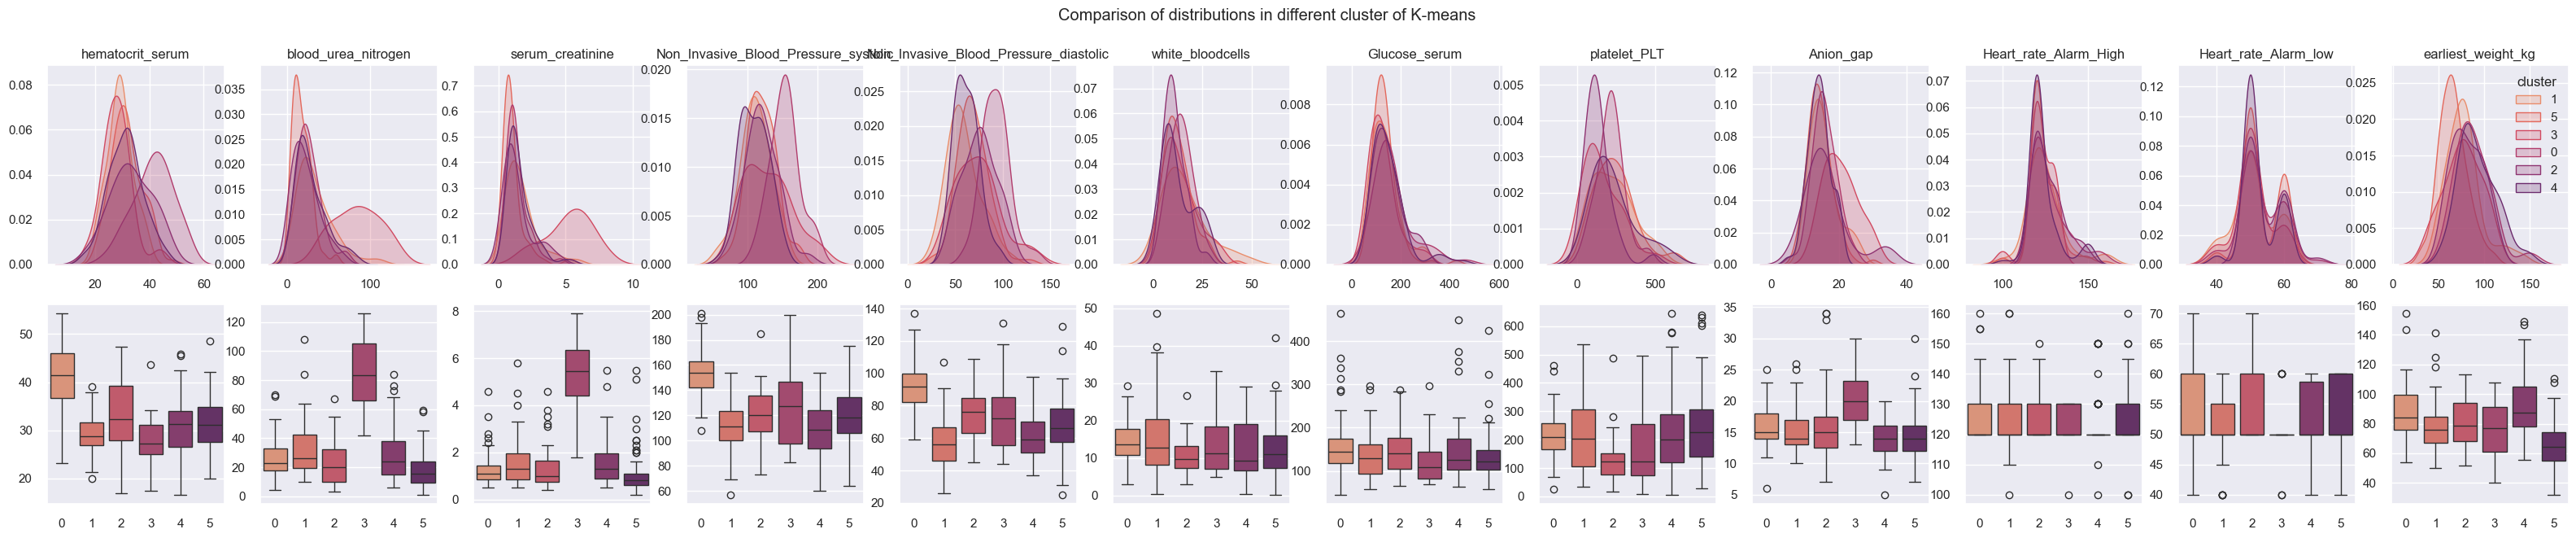

In [59]:
mean_diff.append(plot_mean_difference(df_clean, 'cluster', "Comparison of distributions in different cluster of K-means", colours=palette, features_kde=features_kde))

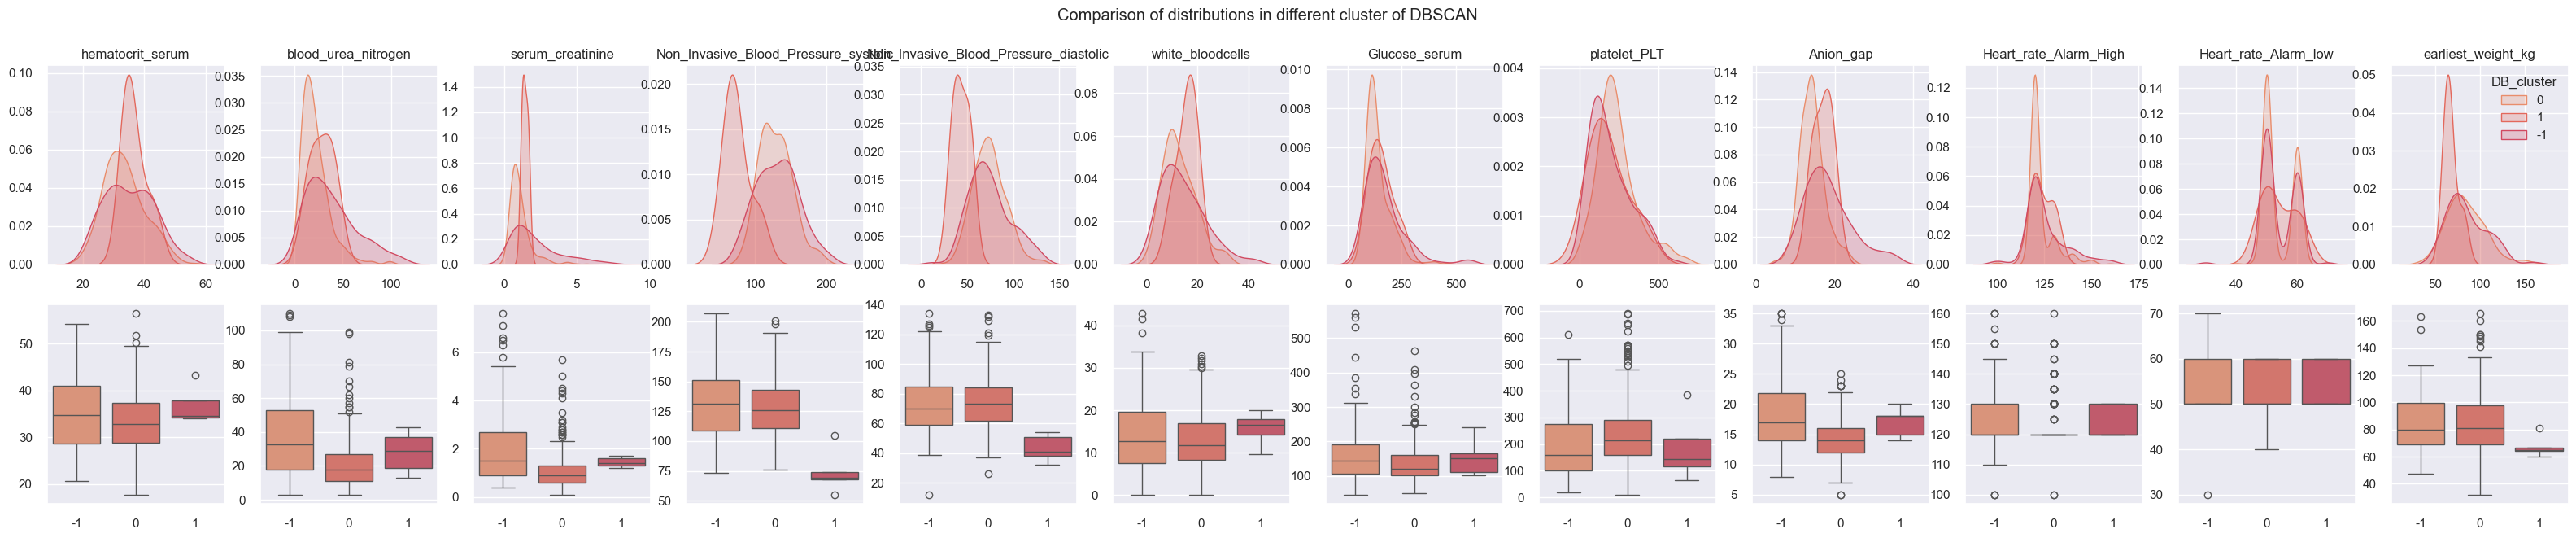

In [66]:
mean_diff.append(plot_mean_difference(df_clean, 'DB_cluster', "Comparison of distributions in different cluster of DBSCAN", colours=palette, features_kde=features_kde))

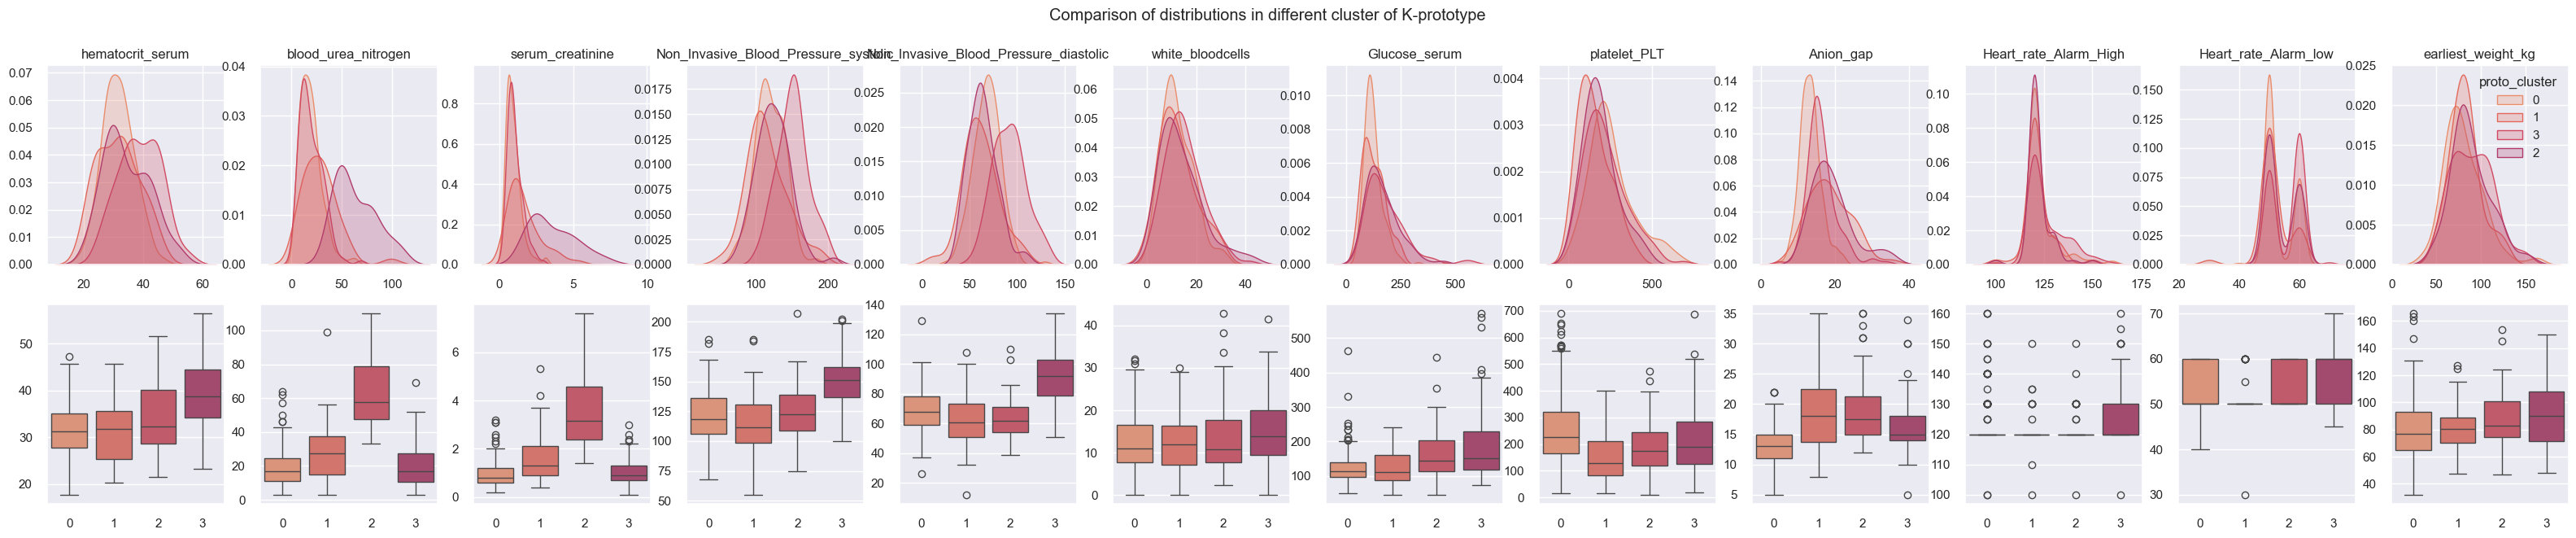

In [67]:
mean_diff.append(plot_mean_difference(df_clean, 'proto_cluster', "Comparison of distributions in different cluster of K-prototype", colours=palette, features_kde=features_kde))

In [68]:
pd.DataFrame(mean_diff).round(3).T.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n & 0 & 1 \\\\\n\\midrule\nhematocrit_serum & 0.074000 & 0.000000 \\\\\nblood_urea_nitrogen & 0.000000 & 0.000000 \\\\\nserum_creatinine & 0.000000 & 0.000000 \\\\\nNon_Invasive_Blood_Pressure_systolic & 0.000000 & 0.000000 \\\\\nNon_Invasive_Blood_Pressure_diastolic & 0.002000 & 0.000000 \\\\\nwhite_bloodcells & 0.170000 & 0.022000 \\\\\nGlucose_serum & 0.001000 & 0.000000 \\\\\nplatelet_PLT & 0.012000 & 0.000000 \\\\\nAnion_gap & 0.000000 & 0.000000 \\\\\nHeart_rate_Alarm_High & 0.037000 & 0.003000 \\\\\nHeart_rate_Alarm_low & 0.913000 & 0.000000 \\\\\nearliest_weight_kg & 0.217000 & 0.001000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Mortality rate

In [69]:
def plot_mortality(label):
    mortality_cluster = []
    x_ax = []
    for c in sorted(df_clean[label].unique()):
        sub = df_clean[df_clean[label] == c]
        mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])
        x_ax.append(c)

    plt.bar(x_ax, mortality_cluster, color=palette)
    plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
    # plt.annotate('Overall 19.84%', xy=(0, 20), xytext=(2.5, 21))

    for c, rate in zip(x_ax, mortality_cluster):
        plt.text(c, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

    plt.xlabel("Cluster")
    plt.ylim([0,100])

def scatter_plot(label):
    for cluster in X_pca[label].unique():
        cluster_data = X_pca[X_pca[label] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}')
    plt.xlabel('PC1')

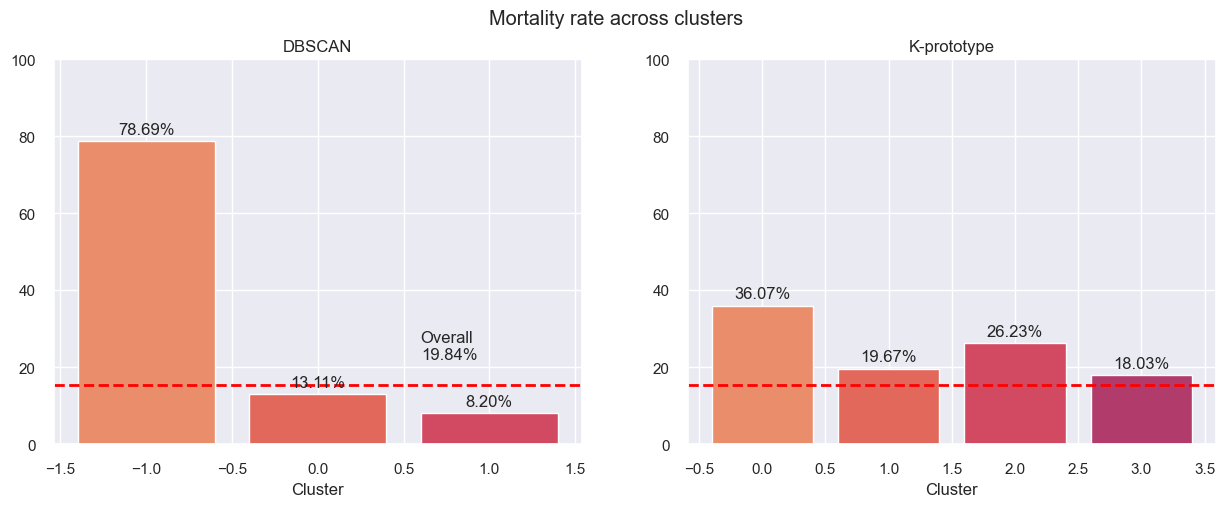

In [76]:
# Mortality rate in each cluster
fig = plt.figure(figsize=(15,5))
fig.suptitle("Mortality rate across clusters")

# plt.subplot(1,3,1)
# plot_mortality('cluster')
# plt.ylabel("Mortality rate (%)")
# plt.title("K-means")

plt.subplot(1,2,1)
plot_mortality('DB_cluster')
plt.title("DBSCAN")
plt.annotate('Overall\n19.84%', xy=(0.6, 20), xytext=(0.6, 22))

plt.subplot(1,2,2)
plot_mortality('proto_cluster')
plt.title("K-prototype")
plt.show()

Text(0.5, 0.98, 'Data distribution based on clusters')

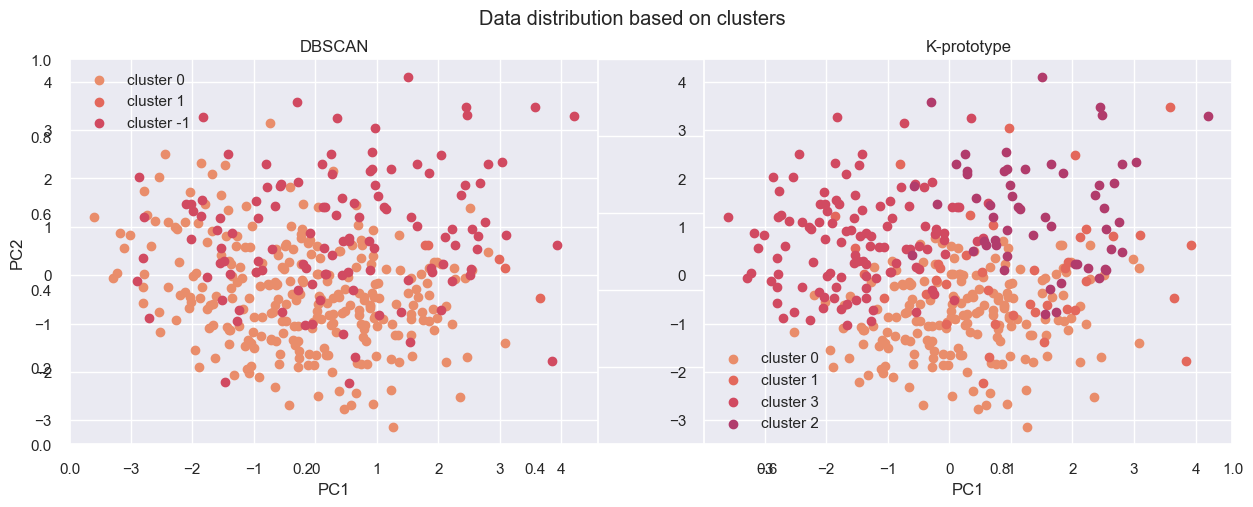

In [72]:
plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# scatter_plot('cluster')

plt.ylabel('PC2')
# plt.title("K-means")
# plt.legend()

plt.subplot(1,2,1)
scatter_plot('DB_cluster')
plt.title("DBSCAN")
plt.legend()

plt.subplot(1,2,2)
scatter_plot('proto_cluster')
plt.title("K-prototype")
plt.legend()

plt.suptitle("Data distribution based on clusters")

In [66]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="K-means", color_discrete_sequence=palette)
fig.show()

In [73]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='DB_cluster', title="DBSCAN", color_discrete_sequence=palette)
fig.show()
fig.write_image("../output/icd_DBSCAN_dist.png")

In [74]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='proto_cluster', title="K-prototype", color_discrete_sequence=palette)
fig.show()
fig.write_image("../output/icd_Kprototype_dist.png")